## Introuduction
I hope who ever is running/reading this kernel is already well know about linear regression models. In spite of that I would like refresh for who already know and give basic background for new. Linear regression is a modelling approach to spectacle the relationship between a dependent variable Y and one or more indepentend variable X. For ones who want to explore more please follow the link [Regression Model](https://en.wikipedia.org/wiki/General_linear_model).

As there are already Great Kernels for this competition, and I would like to thank the following writer for sharing their notebook which I have referenced and has boost my knowledge in regression analysis.
1. [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-dataexploration-with-python) by Pedro Marcelino : Great and very motivational data analysis.

### Assumptions on Multiple regression
* There must be a linear relationship between the outcome variable and the independent variables.  Scatterplots can show whether there is a linear or curvilinear relationship.
* Multivariate Normality–Multiple regression assumes that the residuals are normally distributed.
* No Multicollinearity—Multiple regression assumes that the independent variables are not highly correlated with each other.  This assumption is tested using Variance Inflation Factor (VIF) values.
* Homoscedasticity–This assumption states that the variance of error terms are similar across the values of the independent variables.  A plot of standardized residuals versus predicted values can show whether points are equally distributed across all values of the independent variables.

## Loading required Libraries

In [1]:
import warnings
## Ignoring warnings 
warnings.filterwarnings('ignore')

## Show warning for just once
#warnings.filterwarnings(action='once')
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Loading Data Set

In [2]:
trainData = pd.read_csv('/workspace/python/house-price-predict/train.csv')
testData = pd.read_csv('/workspace/python/house-price-predict/test.csv')

## Exploratory Data Analysis - I

In [3]:
trainData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### List Possible Categorical Variables
Before proceeding to further analysis, first lets try to understand our features. We will first seggerate which features are possible categorical and contineous, which will suppliment us on further analysis for building our model. So for this task lets build a function and lets assume that features with unique values less than 15 are our possilbe categorical features and rest are contineous.

In [4]:
def listFactorVars(dataFrame):
    for col in dataFrame:
        if (len(trainData[col].unique()) < 15):
            print("{} : {}".format(col, trainData[col].unique()))
        else:
            None

listFactorVars(trainData)

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street : ['Pave' 'Grvl']
Alley : [nan 'Grvl' 'Pave']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities : ['AllPub' 'NoSeWa']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope : ['Gtl' 'Mod' 'Sev']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
OverallQual : [ 7  6  8  5  9  4 10  3  1  2]
OverallCond : [5 8 6 7 4 2 3 9 1]
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
MasVnrType : ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
ExterQual : ['Gd' 'TA' 'Ex' 'Fa']
ExterCond : ['TA' 'Gd' 'Fa' 'Po' 'Ex']
Foundation : ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'St

In [5]:
%%html
<style>
rendered_html tr, .rendered_html th, .rendered_html td
{ 
 font-family: "Times New Roman", Times, serif;
 text-align: left;
}
</style>

Next to gain some for insights about the features let's think out of the box, what generalized features would you look if you were buying a house. Hmmm probably it would be location (e.g city or village etc.), plot(area, structure etc.) and house(floors, bathrooms, kitchen blah blah..) for me as like Pedro Marcelino. Now lets categorize the features. 

House Features | Plot Features | Location Features
--------------- | --------------- | ------------------ 
MSSubClass, Utilities, BldgType, HouseStyle,  GarageYrBlt|MSZoning |Street
OverallQual, OverallCond, YearBuilt, YearRemodAdd, GarageCars|LandSlope|Condition2
RoofStyle, RoofMatl, Exterior1st, Exterior2nd, OpenPorchSF|LotShape|Neighborhood
MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation|LotConfig|
BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, EnclosedPorch|LotFrontage|
BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF| LotArea|
TotalBsmtSF, Heating, HeatingQC, CentralAir, MiscVal|LandContour|
Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF,Fence||
GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath||
HalfBath, Bedroom, Kitchen, KitchenQual, TotRmsAbvGrd||
Functional, Fireplaces, FireplaceQu, GarageType, GarageFinish||
GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF||
3SsnPorch, ScreenPorch, PoolArea, PoolQC, MiscFeature||
MoSold, YrSold, SaleType, SaleCondition||Condition1

As we have seen lots of features under three category, but from pool of features from those category which would be you focus specifically. Hmmmm... I would choose *MSSubClass, LotArea, Street, Neighborhood, Condition1, BldgType, OverallQual, YearBuilt, ExterQual , Foundation, Electrical, GarageType ,GrLivArea.*

We will expolre more in detail in sebsequent phases. But for now lets investigate the relationship of above listed features with variable SalePrice.

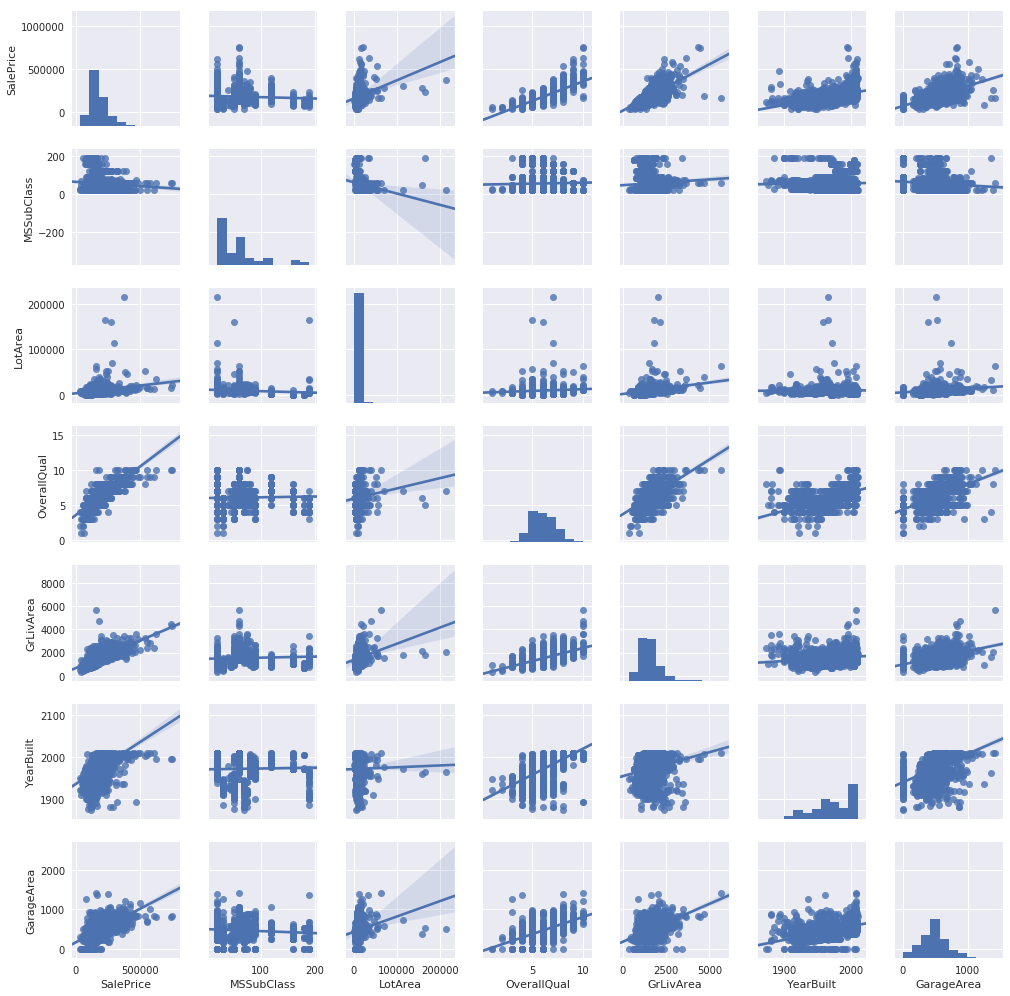

In [6]:
sns.set()
cols = ['SalePrice', 'MSSubClass', 'LotArea', 'OverallQual','GrLivArea','YearBuilt','GarageArea']
sns.pairplot(trainData[cols], kind="reg", size = 2)
plt.show();

Okay, Our preliminary prediction was somewhat right as all features are strongly corelated to SalePrice but we missed MSSubClass. Now lets look the features we considered which are categorical in nature and their relationship with SalePrice.

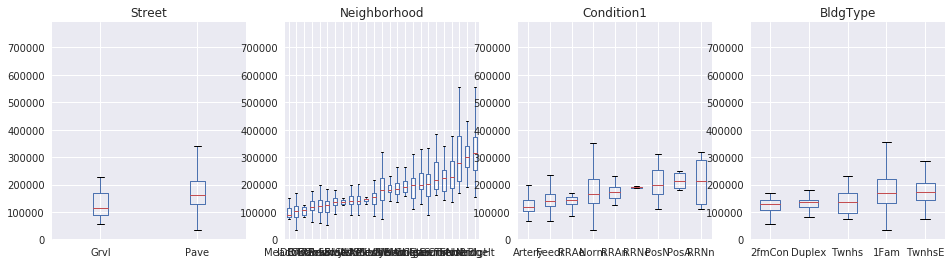

In [7]:
def sortBoxplot(df, by,column):
    fig = plt.figure(figsize=(16,4))
    i=141
    for r in by:
        ax = fig.add_subplot(i)
        ax.set_title(r)
        df1 = pd.DataFrame({col:vals[column] for col,vals in df.groupby(r)})
        mean=df1.median().sort_values()
        df1[mean.index].boxplot(rot=0,ax=ax)
        i=i+1
        
sortBoxplot(trainData, by=['Street','Neighborhood','Condition1','BldgType'],column='SalePrice')

From above plots we can get a basic idea that those categorical variable does not show strong corelation with our Predicion variable SalePrice. This was our naive approach. There could exists more important features which may impact more on SalePrice than we have list. Next we will analyze the realtionship between SalePrice and other features by calculating a correlation matrix that shows the correlation coefficient for each pair of variable and represent graphically via a correlation matrix plot in the form of a heatmap.


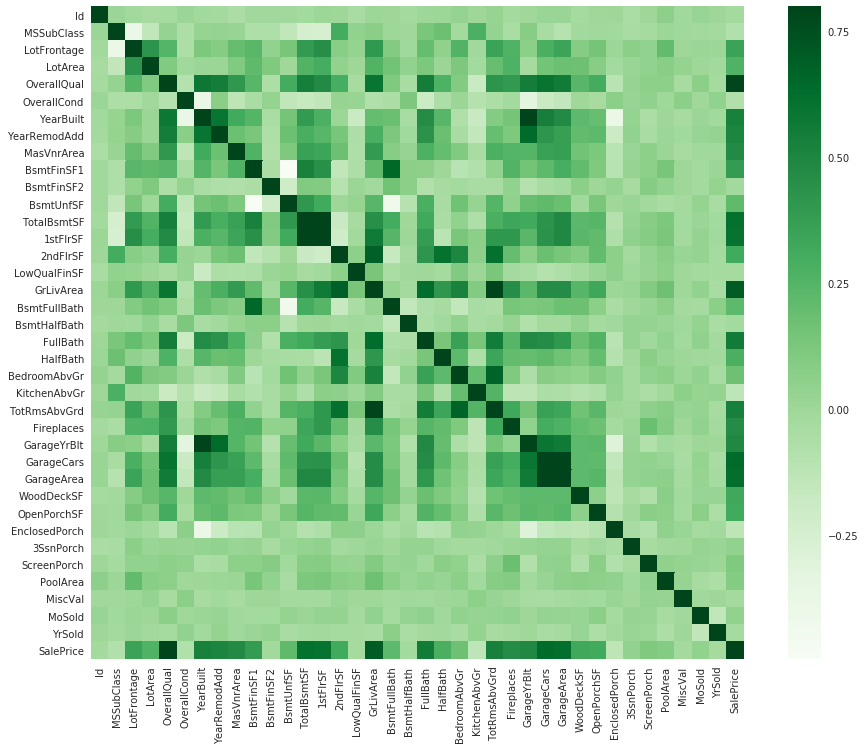

In [8]:
corrmat = trainData.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Greens");

As we have visualized the correlation matrix now lets zoom it and withdraw 15 features which are more correlated to SalePrice.

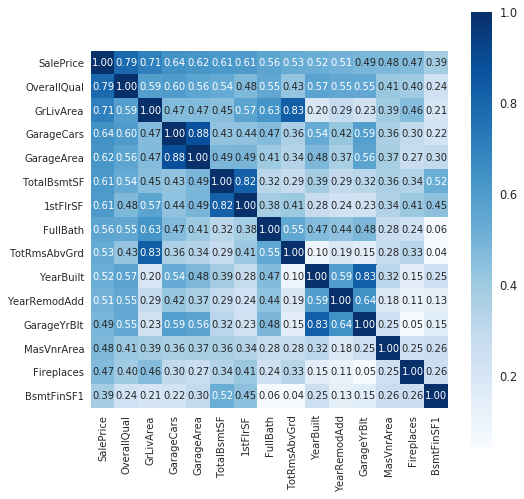

In [9]:
# Number of features to include
k = 15
# find the column names having highest correlation with SalePrice
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# Subset the precomputed corrmat matrix containing with 15x15
zoommat = corrmat.nlargest(k, 'SalePrice')[cols]
# finally plot the zoomed heatmap
f, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.15)
plot = sns.heatmap(zoommat, cbar=True, annot=True, square=True, cmap="Blues", fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)

## Feature Engineering
Doing some exploratory analysis and hanging around with feature analysis, now its time to do some feature engineering. Here we will merge the test dataset and trining dataset to a single full dataset. Then we will impute the imssing values, handle extreme values, remove outliars, and introduce and drop some features.

In [10]:
trainData['dataType']='train'
testData['dataType']='test'
SalePrice = trainData['SalePrice']
fullData = pd.concat((trainData, testData)).reset_index(drop=True)
fullData.drop(['SalePrice'], axis=1, inplace=True)
del testData
del trainData

### Cleaning Data and Imputing Missing values
First lets view percentage and count of missing values for all features within the merged data set data. As we will be not using the features which have missing values > 15%. As imputing and inclusion of them with in our model may introduce extra noise and outlier in our data.

In [11]:
nullcount = fullData.isnull().sum().sort_values(ascending=False)
percent = (fullData.isnull().sum()/fullData.isnull().count()).sort_values(ascending=False)
misData = pd.concat([nullcount[nullcount > 0], percent[percent > 0]], axis=1, keys=['Total','Percent'])
misData[misData['Percent'] > 0]

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471


#### Imputing Missing values for Electrical
We have observed that the Electrical feature is of Categorical type. Before imputing Missing values lets gain some insights about feature Electrical. 

In [12]:
def giveCountsinDF(dataFrame, colum, inlinePrint=False):
    for col in colum:
        nulcnt = pd.crosstab(index=dataFrame[col], columns="count")
        nulcnt.columns=['Value Count']
        if(inlinePrint):
            display(nulcnt)
            #print(nulcnt)
            #print("\n")
        else:
            return(nulcnt)

In [13]:
giveCountsinDF(fullData, ['Electrical'])

,Value Count
Electrical,
FuseA,188
FuseF,50
FuseP,8
Mix,1
SBrkr,2671


Ahh! most of the values are for category __SBrkr__, hence we will assign the values of it for missing values.

In [14]:
fullData['Electrical'].fillna("SBrkr", inplace=True)
fullData['Electrical'].isnull().sum()

0

#### Imputing Missing values for KitchenQual

We will use the value of the category with maximum count in place of Nan.

In [15]:
giveCountsinDF(fullData, ['KitchenQual'])

,Value Count
KitchenQual,
Ex,205
Fa,70
Gd,1151
TA,1492


In [16]:
fullData['KitchenQual'].fillna("TA", inplace=True)
fullData['KitchenQual'].isnull().sum()

0

#### Imputing Missing values for Exterior1st, Exterior2nd

We will use the value of the category with maximum count in place of Nan.

In [17]:
giveCountsinDF(fullData, ['Exterior1st','Exterior2nd'], True)

,Value Count
Exterior1st,
AsbShng,44
AsphShn,2
BrkComm,6
BrkFace,87
CBlock,2
CemntBd,126
HdBoard,442
ImStucc,1
MetalSd,450


,Value Count
Exterior2nd,
AsbShng,38
AsphShn,4
Brk Cmn,22
BrkFace,47
CBlock,3
CmentBd,126
HdBoard,406
ImStucc,15
MetalSd,447


In [18]:
fullData['Exterior1st'].fillna("VinylSd", inplace=True)
fullData['Exterior2nd'].fillna("VinylSd", inplace=True)

#### Imputing missing values for MasVnrType
The feature MasVnrType is also categorical type.

In [19]:
giveCountsinDF(fullData, ['MasVnrType'])

,Value Count
MasVnrType,
BrkCmn,25
BrkFace,879
None,1742
Stone,249


In [20]:
fullData['MasVnrType'].fillna("None", inplace=True)
fullData['MasVnrType'].isnull().sum()

0

#### Imputing missing values for MasVnrArea
As the variable is integer hence, lets view its central properties.

In [21]:
fullData['MasVnrArea'].describe()

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Ohhh!! median is 0, so we can assume that there is no masion area. So we will simply replace the Nan values with median.

In [22]:
fullData['MasVnrArea'].fillna(0.0, inplace=True)
fullData['MasVnrArea'].isnull().sum()

0

#### Imputing missing values for features related to basement
As all the features related to basement with missing values are categorical type, we can review them as below:

In [23]:
giveCountsinDF(fullData, ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtFullBath',
                          'BsmtHalfBath'], True)

,Value Count
BsmtQual,
Ex,258
Fa,88
Gd,1209
TA,1283


,Value Count
BsmtCond,
Fa,104
Gd,122
Po,5
TA,2606


,Value Count
BsmtFinType1,
ALQ,429
BLQ,269
GLQ,849
LwQ,154
Rec,288
Unf,851


,Value Count
BsmtFinType2,
ALQ,52
BLQ,68
GLQ,34
LwQ,87
Rec,105
Unf,2493


,Value Count
BsmtExposure,
Av,418
Gd,276
Mn,239
No,1904


,Value Count
BsmtFullBath,
0.0,1705
1.0,1172
2.0,38
3.0,2


,Value Count
BsmtHalfBath,
0.0,2742
1.0,171
2.0,4


Hmmmm! Before imputing missing values let's think that, the house we are buying my do not have basement features at all that are missing. Hence lets's impute the missing values as another category as __None__ for all features with Nan. Before doing so, first lets check if the all missing vlaues of the features are form the same row or not.

In [24]:
def checkSameRow(df,idx ,columns, count=5):
    tempdf = df[df[idx].isnull()].index
    return(df.loc[tempdf,columns].head(count))

columns=['Id','BsmtQual','BsmtCond', 'BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtFullBath',
         'BsmtUnfSF','BsmtHalfBath','TotalBsmtSF']
checkSameRow(fullData, 'BsmtCond', columns, 5)

,Id,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure,BsmtFullBath,BsmtUnfSF,BsmtHalfBath,TotalBsmtSF
17,18,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
39,40,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
90,91,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
102,103,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
156,157,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


Bingo! All the features realted to basement are from same rows. Hence we can safely treat them as those houses do not contain there features.

In [25]:
fullData['BsmtQual'].fillna("None", inplace=True)
fullData['BsmtCond'].fillna("None", inplace=True)
fullData['BsmtFinType1'].fillna("None", inplace=True)
fullData['BsmtFinType2'].fillna("None", inplace=True)
fullData['BsmtExposure'].fillna("No", inplace=True)

print(fullData['BsmtFinSF1'].describe())
print("\n")
print(fullData['BsmtFinSF2'].describe())
print("\n")
print(fullData['BsmtUnfSF'].describe())
print("\n")
print(fullData['TotalBsmtSF'].describe())

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
25%       220.000000
50%       467.000000
75%       805.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


We can view that all most data are 0, hence we will impute missing values as to be 0.0.

In [26]:
fullData['BsmtFinSF1'].fillna(0.0, inplace=True)
fullData['BsmtFinSF2'].fillna(0.0, inplace=True)
fullData['BsmtUnfSF'].fillna(467.0, inplace=True)

In [27]:
columns=['Id','BsmtQual','BsmtCond', 'BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtFullBath','BsmtHalfBath','TotalBsmtSF']
checkSameRow(fullData, 'BsmtFullBath', columns, 5)

,Id,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
2120,2121,None,None,None,None,No,NaN,NaN,NaN
2188,2189,None,None,None,None,No,NaN,NaN,0.0


In [28]:
fullData['BsmtFullBath'].fillna(0.0, inplace=True)
fullData['BsmtHalfBath'].fillna(0.0, inplace=True)
columns=['Id','BsmtQual','BsmtCond', 'BsmtFinType1','BsmtFinType2','BsmtExposure','BsmtFullBath','BsmtHalfBath','TotalBsmtSF']
checkSameRow(fullData, 'TotalBsmtSF', columns, 5)

,Id,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtExposure,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
2120,2121,None,None,None,None,No,0.0,0.0,NaN


In [29]:
fullData['TotalBsmtSF'].fillna(0.0, inplace=True)

#### Imputing missing values for features related to Garage

In [30]:
giveCountsinDF(fullData, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageCars'], True)

,Value Count
GarageCond,
Ex,3
Fa,74
Gd,15
Po,14
TA,2654


,Value Count
GarageType,
2Types,23
Attchd,1723
Basment,36
BuiltIn,186
CarPort,15
Detchd,779


,Value Count
GarageFinish,
Fin,719
RFn,811
Unf,1230


,Value Count
GarageQual,
Ex,3
Fa,124
Gd,24
Po,5
TA,2604


,Value Count
GarageCars,
0.0,157
1.0,776
2.0,1594
3.0,374
4.0,16
5.0,1


In [31]:
columns=['Id','GarageType','GarageFinish','GarageCond','GarageQual','GarageYrBlt','GarageCars']
checkSameRow(fullData, 'GarageCond', columns, 5)

,Id,GarageType,GarageFinish,GarageCond,GarageQual,GarageYrBlt,GarageCars
39,40,NaN,NaN,NaN,NaN,NaN,0.0
48,49,NaN,NaN,NaN,NaN,NaN,0.0
78,79,NaN,NaN,NaN,NaN,NaN,0.0
88,89,NaN,NaN,NaN,NaN,NaN,0.0
89,90,NaN,NaN,NaN,NaN,NaN,0.0


Same case for Garage features. So lets assign all the missing values for categorical values to None and 0.0 to feature GarageYrBlt.

In [32]:
fullData['GarageType'].fillna("None", inplace=True)
fullData['GarageFinish'].fillna("None", inplace=True)
fullData['GarageCond'].fillna("None", inplace=True)
fullData['GarageQual'].fillna("None", inplace=True)
fullData['GarageYrBlt'].fillna(0.0, inplace=True)

print(fullData['GarageArea'].describe())
print("\n")
print(fullData['GarageCars'].describe())

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64


count    2918.000000
mean        1.766621
std         0.761624
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64


In [33]:
columns=['Id','GarageType','GarageFinish','GarageCond','GarageQual','GarageYrBlt','GarageCars','GarageArea']
checkSameRow(fullData, 'GarageArea', columns, 5)

,Id,GarageType,GarageFinish,GarageCond,GarageQual,GarageYrBlt,GarageCars,GarageArea
2576,2577,Detchd,None,None,None,0.0,NaN,NaN


In [34]:
fullData['GarageCars'].fillna(0.0, inplace=True)
fullData['GarageArea'].fillna(0.0, inplace=True)

#### Imputing missing values for Functional 

In [35]:
giveCountsinDF(fullData, ['Functional'])

,Value Count
Functional,
Maj1,19
Maj2,9
Min1,65
Min2,70
Mod,35
Sev,2
Typ,2717


In [36]:
columns=['Id','Functional','OverallCond']
checkSameRow(fullData, 'Functional', columns, 5)

,Id,Functional,OverallCond
2216,2217,NaN,5
2473,2474,NaN,1


In [37]:
fullData.loc[2216,['Functional']] = 'Sev'
fullData.loc[2473,['Functional']] = 'Mod'

#### Imputing missing values for Utilities

In [38]:
giveCountsinDF(fullData, ['Utilities'])

,Value Count
Utilities,
AllPub,2916
NoSeWa,1


In [39]:
fullData['Utilities'].fillna('AllPub', inplace=True)

#### Imputing missing values for SaleType

In [40]:
giveCountsinDF(fullData, ['SaleType'])

,Value Count
SaleType,
COD,87
CWD,12
Con,5
ConLD,26
ConLI,9
ConLw,8
New,239
Oth,7
WD,2525


In [41]:
fullData['SaleType'].fillna('WD', inplace=True)

#### Imputing missing values for MSZoning

In [42]:
giveCountsinDF(fullData, ['MSZoning'])

,Value Count
MSZoning,
C (all),25
FV,139
RH,26
RL,2265
RM,460


In [43]:
fullData['MSZoning'].fillna('RL', inplace=True)

#### Imputing missing values for feature LotFrontage

In [44]:
fullData['LotFrontage'].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Lets develop a function to impute the imssing variables. We will use RandomForest to impute the missing values for LotFrontage.

In [45]:
def imputeMissing(df, idx, predictors):
    tempdf = df[df[outcome].isnull()].index
    tempndf = df[df[idx].notnull()].index
    model = RandomForestClassifier(n_estimators=100)
    model.fit(df.loc[tempndf, predictors], df.loc[tempndf, [outcome]])
    predict = model.predict(df.loc[tempndf, predictors])
    j=0;
    for i in tempdf:
        df.loc[i,outcome] = predict[j]
        j=j+1
    return(df)

We will use the other lot features to impute the missing values for LotFrontage variable.

In [46]:
predictors=['LotArea','Street','LotShape','LandContour','LotConfig']
outcome='LotFrontage'

## Encode the variable to numeric 
var_mod = ['Street','LotShape','LandContour','LotConfig']
le = LabelEncoder()
for i in var_mod:
    fullData[i] = le.fit_transform(fullData[i].astype(str))

fullData = imputeMissing(fullData,outcome,predictors)
fullData['LotFrontage'].isnull().sum()

0

Now, we are done with imputing missing values as we will left all other features with missing values untoched as further imputation may make our model more worse.

### Outliars/Noise filtering and normalization
From the plot in line 7 (__Out[7]__) we witnessed that the features with extreme values are __LotArea__, __GrLivArea__. Now lets explore their relationship with SalePrice. Before proceeding let's first split out combined data to their respective tag's i.e. train and test.

In [47]:
trainIdx = fullData[fullData['dataType']=='train'].index
testIdx = fullData[fullData['dataType']=='test'].index
SalePrice = pd.DataFrame(data=SalePrice)
trainData = fullData.iloc[trainIdx].join(SalePrice)
testData = fullData.iloc[testIdx]

Let's start analyzing our Prediction variable SalePrice and see if it contains extreme values or outliars.

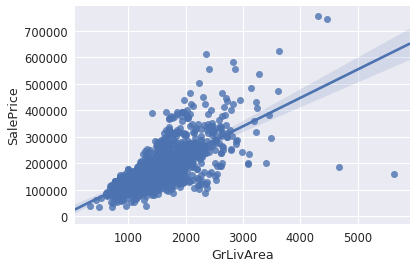

In [48]:
sns.regplot(x=trainData["GrLivArea"], y=trainData["SalePrice"])

From the above plot we can witness that two values towards right downwards seems extreme values. Hence we will omit these traning data from our dataset treating them as Outliars.

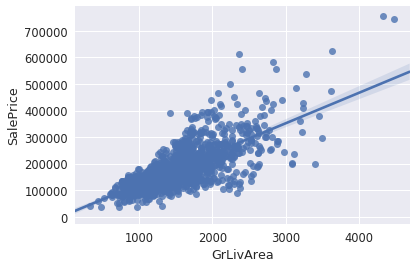

In [49]:
trainData = trainData.drop(trainData[(trainData['GrLivArea']>4000) & (trainData['SalePrice']<200000)].index)
sns.regplot(x=trainData["GrLivArea"], y=trainData["SalePrice"])

Our assumption in regression is normality. So lets check the status of SalePrice feature.

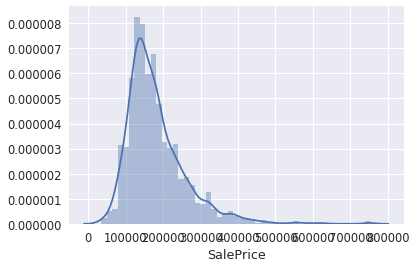

In [50]:
sns.distplot(trainData["SalePrice"])

Ahh! its skwed, let's look the QQ-plot.

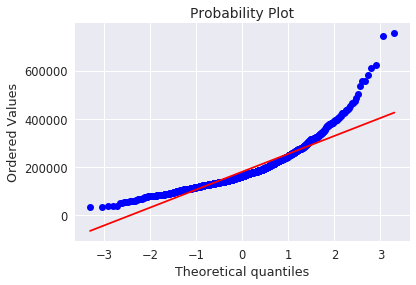

In [51]:
fig = plt.figure()
res = stats.probplot(trainData['SalePrice'], plot=plt)

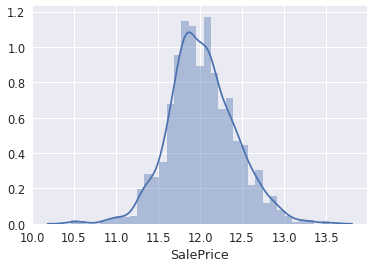

In [52]:
trainData["SalePrice"] = np.log(trainData["SalePrice"])
sns.distplot(trainData["SalePrice"])

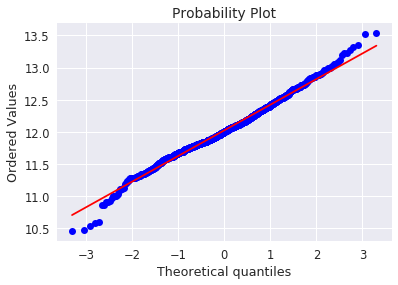

In [53]:
fig = plt.figure()
res = stats.probplot(trainData['SalePrice'], plot=plt)

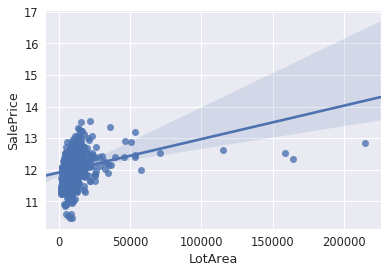

In [54]:
sns.regplot(x=trainData["LotArea"], y=trainData["SalePrice"])

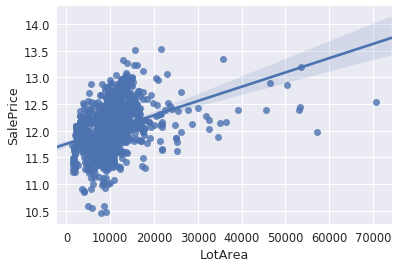

In [55]:
trainData = trainData.drop(trainData[(trainData['LotArea']>100000) & (trainData['SalePrice']<450000)].index)
sns.regplot(x=trainData["LotArea"], y=trainData["SalePrice"])

In [56]:
print("Skewness: %f" % trainData['SalePrice'].skew())
print("Kurtosis: %f" % trainData['SalePrice'].kurt())

Skewness: 0.124211
Kurtosis: 0.824106


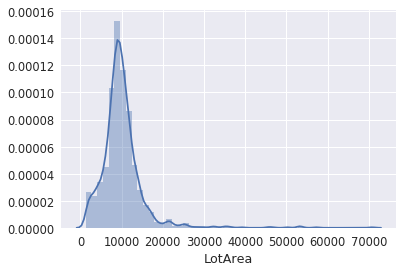

In [57]:
sns.distplot(trainData["LotArea"])

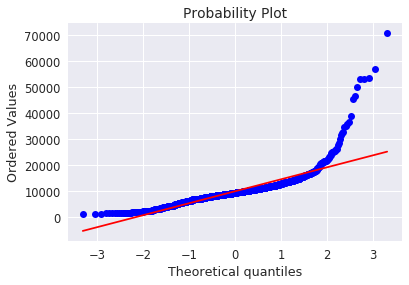

In [58]:
fig = plt.figure()
res = stats.probplot(trainData['LotArea'], plot=plt)

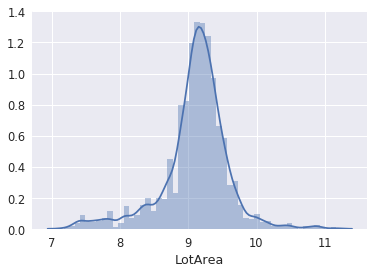

In [59]:
trainData["LotArea"] = np.log(trainData["LotArea"])
sns.distplot(trainData["LotArea"])

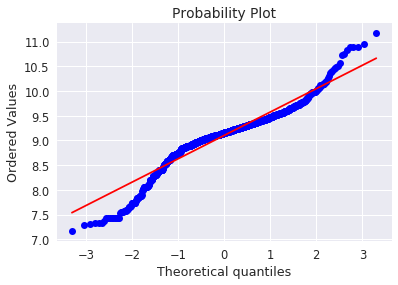

In [60]:
fig = plt.figure()
res = stats.probplot(trainData['LotArea'], plot=plt)

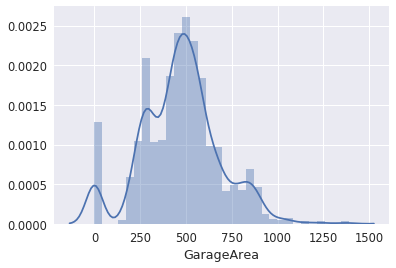

In [61]:
sns.distplot(trainData["GarageArea"])

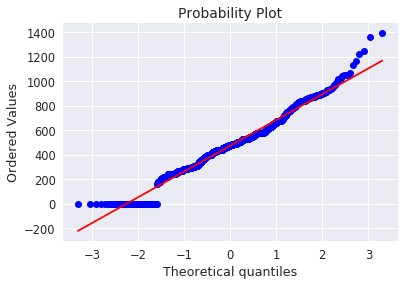

In [62]:
fig = plt.figure()
res = stats.probplot(trainData['GarageArea'], plot=plt)

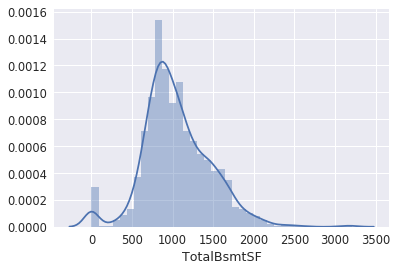

In [63]:
sns.distplot(trainData["TotalBsmtSF"])

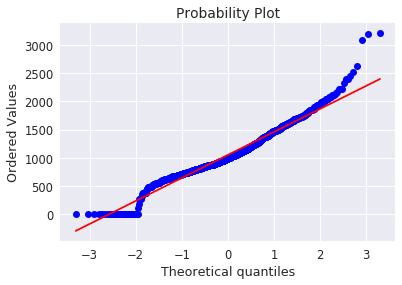

In [64]:
fig = plt.figure()
res = stats.probplot(trainData['TotalBsmtSF'], plot=plt)

## Design and building Predictive Model

In [69]:
def modelfit(alg, dataFrame, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dataFrame[predictors], dataFrame['SalePrice'])
        
    #Predict training set:
    dataFrame_predictions = alg.predict(dataFrame[predictors])
    #dataFrame_predprob = alg.predict_proba(dataFrame[predictors])[:,1]
    
    #Perform cross-validation:
    #if performCV:
    #    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['SalePrice'], 
    #                                                cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    #print ("\nModel Report")
    print ("Accuracy : {}".format(metrics.accuracy_score(dataFrame['SalePrice'].values, dtrain_predictions)))
    print ("AUC Score (Train): {}".format(metrics.roc_auc_score(dataFrame['SalePrice'], dtrain_predprob)))
    
    #if performCV:
    #    print ("CV Score : Mean - {}| Std - {} | Min - {} | Max - {}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    #if printFeatureImportance:
    #    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    #    feat_imp.plot(kind='bar', title='Feature Importances')
    #    plt.ylabel('Feature Importance Score')
        


In [74]:
skipedCols = ['SalePrice', 'PoolQC','MiscFeature','Alley','Id','Fence','FireplaceQu','dataType']
#predictors=['OverallQual','LotArea']

predictors = [x for x in trainData.columns if x not in skipedCols]

le = LabelEncoder()
for i in predictors:
    trainData[i] = le.fit_transform(trainData[i].astype(str))

trainData.dtypes

#gbm0 = GradientBoostingClassifier(random_state=10)
#modelfit(gbm0, train, predictors)


1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType           int64
BsmtCond           int64
BsmtExposure       int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtFinType1       int64
BsmtFinType2       int64
BsmtFullBath       int64
BsmtHalfBath       int64
BsmtQual           int64
BsmtUnfSF          int64
CentralAir         int64
Condition1         int64
Condition2         int64
Electrical         int64
EnclosedPorch      int64
ExterCond          int64
ExterQual          int64
Exterior1st        int64
Exterior2nd        int64
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation         int64
FullBath           int64
                  ...   
LowQualFinSF       int64
MSSubClass         int64
MSZoning           int64
MasVnrArea         int64
MasVnrType         int64
MiscFeature       object
MiscVal            int64
MoSold             int64
Neighborhood       int64


In [75]:
from sklearn.ensemble import GradientBoostingRegressor
gbm0 = GradientBoostingRegressor(random_state=10)
#modelfit(gbm0, trainData, predictors)
gbm0.fit(trainData[predictors], trainData['SalePrice'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)

In [ ]:
# Data School

## References
1. [Assumptions of Multiple linear regression](http://www.statisticssolutions.com/assumptions-of-multiple-linear-regression/)
2. [A Little Book of Python for Multivariate Analysis](http://python-for-multivariate-analysis.readthedocs.io/a_little_book_of_python_for_multivariate_analysis.html)
3. [A Guide to Gradient Boosted Trees with XGBoost in Python](https://jessesw.com/XG-Boost/)
4. [Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
5. [Metrics To Evaluate Machine Learning Algorithms in Python](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)
6. [How to increase the model accuracy of logistic regression in Scikit python?
](https://stackoverflow.com/questions/38077190/how-to-increase-the-model-accuracy-of-logistic-regression-in-scikit-python)
7. [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)